In [1]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 3.1 MB 7.2 MB/s 
     |████████████████████████████████| 61 kB 610 kB/s 
     |████████████████████████████████| 895 kB 61.4 MB/s 
     |████████████████████████████████| 3.3 MB 56.1 MB/s 
     |████████████████████████████████| 596 kB 70.6 MB/s 
     |████████████████████████████████| 1.2 MB 10.4 MB/s 


In [2]:
import datetime
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

from transformers import AutoModel, AutoTokenizer, AutoConfig

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import compute_class_weight

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from IPython.display import display, HTML

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def get_data_loader(dataset, batch_size=16, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(dataset, batch_size=batch_size, generator=g)

In [5]:
class FusionDataset(IterableDataset):
    def __init__(self, sequences, masks, features, labels, fsize=(40,9601)):
        self.sequences = sequences
        self.masks = masks
        self.labels = labels
        self.features = features
        self.fsize = fsize
    
    def __get__(self,index):
      if self.features[index].shape[1] < self.fsize[1]:
        self.features[index] = torch.hstack((self.features[index],
                                             torch.zeros(self.fsize[0],self.fsize[1]-self.features[index].shape[1])))
      return self.features[index].reshape((1,)+self.features[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def get_data_loader(self, batch_size=16, random_seed=42):
        return get_data_loader(self, batch_size, random_seed)
    
    @staticmethod
    def _prepare_data_(data, sequences, masks, ids, target='RagamCode', audfeature='mel_spec', fsize=(40,9601)):
      lbls = torch.tensor([data[target].iloc[x] for x in ids])
      features = [data[audfeature].iloc[x] for x in ids] # aud feature is already tensor
      return FusionDataset(sequences[ids], masks[ids], features, lbls, fsize)

    @staticmethod
    def prepare_data(data, sequences, masks, train_ids, test_ids, target='RagamCode', audfeature='mel_spec', fsize=(40,9601)):
      return FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize), FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize)

In [6]:
class FusionModel(nn.Module):
  def __init__(self, transformer, n_labels=2, dropout=0.1):
    super().__init__()
    self.VEC_SIZE = 768
    self.transformer = transformer
    self.aud_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,1), padding='same'),            
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,2), padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=4),
            nn.Flatten()
        )
    self.fusion = nn.Sequential(nn.Linear(48000+self.VEC_SIZE, 1000),
                                nn.ReLU(),
                                nn.Dropout(dropout),
                                nn.Linear(1000, n_labels))
  def forward(self, sequence, mask, aud):
    _, cls = self.transformer(sequence, attention_mask=mask, return_dict=False)
    aud = self.aud_layer(aud)
    x = torch.cat((aud, cls),1)
    return self.fusion(x)

In [7]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [8]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(labels),
                                         y=labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [9]:
def get_metrics(actual, predicted, average='micro'):
  return f1_score(actual, predicted, average=average), precision_score(actual, predicted, average=average), recall_score(actual, predicted, average=average)

In [10]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, validation_labels,
                       validation_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['validation_predictions'] = validation_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['validation_labels'] = validation_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores


def update_results_dict(results, train_labels, train_predictions, validation_labels, validation_predictions,
                        test_lbls, test_preds,
                        average='micro', pos_label=1):
    results['train_precision'].append(precision_score(train_labels, train_predictions, average=average))
    results['train_recall'].append(recall_score(train_labels, train_predictions, average=average))
    results['train_f1'].append(f1_score(train_labels, train_predictions, average=average))
    results['validation_precision'].append(precision_score(validation_labels, validation_predictions, average=average))
    results['validation_recall'].append(recall_score(validation_labels, validation_predictions, average=average))
    results['validation_f1'].append(
        f1_score(validation_labels, validation_predictions, average=average))
    results['test_precision'].append(precision_score(test_lbls, test_preds, average=average))
    results['test_recall'].append(recall_score(test_lbls, test_preds, average=average))
    results['test_f1'].append(
        f1_score(test_lbls, test_preds, average=average))
    results['train_labels'].append([train_labels])
    results['validation_labels'].append([validation_labels])
    results['test_labels'].append([test_lbls])
    results['train_predictions'].append([train_predictions])
    results['validation_predictions'].append([validation_predictions])
    results['test_predictions'].append([test_preds])
    return results

In [11]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
    if is_training:
        model.train()
    else:
        model.eval()
    total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
    for step, batch in enumerate(dataset):
        # push the batch to gpu
        batch = [r.to(run_on) for r in batch]
        sequences, masks, features, labels = batch
        if is_training:
            for o in optimizer:
                o.zero_grad()
            model.zero_grad()
            predictions = model(sequences, masks, features)
        else:
            with torch.no_grad(): 
              predictions = model(sequences, masks, features)
        # compute the loss between actual and predicted values
        loss = loss_fcn(predictions, labels)
        predictions = predictions.detach().cpu().numpy()
        total_loss = total_loss + loss.item()
        if is_training:
            loss.backward()  # backward pass to calculate the gradients
            if clip_at:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
            # update parameters
            for o in optimizer:
                o.step()
        # append the model predictions
        model_predictions.append(predictions)
        model_labels.append(labels.detach().cpu().numpy())
        del batch
    # compute the training loss of the epoch
    avg_loss = total_loss / len(dataset)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    model_predictions = np.concatenate(model_predictions, axis=0)
    model_labels = np.concatenate(model_labels, axis=0)
    # returns the loss and predictions
    model_predictions = np.argmax(model_predictions, axis=1)
    return avg_loss, model_predictions, model_labels

In [12]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'

    def subplot_routine(key1, key2, title, loss=False, key3=None):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        if key3:
          plt.plot([x for k in results for x in results[k][key3]])
        plt.grid()
        plt.xlabel(x_label)
        if key3:
          plt.legend([f'{x} {title}' for x in ['Train', 'Val','Test']])
        else:
          plt.legend([f'{x} {title}' for x in ['Train', 'Val']])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    plt.subplot(2,1,1)
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2,1,2)
    subplot_routine('train_f1', 'validation_f1', 'F1', key3='test_f1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [13]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by=['validation_f1', 'train_f1'], ascending=False, inplace=True)
    return p

In [14]:
def load_tx_model(rootpath):
  return AutoModel.from_pretrained(os.path.join(rootpath,'pytorch_model.bin'), local_files_only=True,
                                  config=AutoConfig.from_pretrained(os.path.join(rootpath,'config.json')))

In [15]:
def predict_test_data(model, chkpoint, test_data, gpu, feature='mel_spec', target='RagamCode'):
  txt = list(test_data.apply(lambda x: x.Lyric, axis=1))
  sequences, masks = get_seq_masks(chkpoint, txt)
  model = model.to(gpu)
  ds = FusionDataset(sequences, masks, test_data[feature].tolist(), test_data[target].tolist())
  model.eval()
  preds, truth = [], []
  for step, batch in enumerate(ds.get_data_loader(16)):
    batch = [r.to(gpu) for r in batch]
    sequences, masks, features, labels = batch
    with torch.no_grad():
      preds_batch = model(sequences, masks, features)
    preds_batch = preds_batch.detach().cpu().numpy()
    preds.append(preds_batch)
    truth.append(labels.detach().cpu().numpy())
    del batch
  preds = np.concatenate(preds, axis=0)
  truth = np.concatenate(truth, axis=0)
  preds = np.argmax(preds, axis=1)
  return preds, truth

In [16]:
def train_model(data, test_data, sequences, masks, rootpath, gpu, chkpoint, **kwargs):
    start_time = datetime.datetime.now()

    n_labels = kwargs['n_labels']
    title = kwargs['title']
    random_seed = kwargs['random_seed'] if 'random_seed' in kwargs else 42
    report = kwargs['report'] if 'report' in kwargs else 20
    lstm = kwargs['lstm'] if 'lstm' in kwargs else False
    lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
    clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
    k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
    balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
    dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.1
    plot = kwargs['plot'] if 'plot' in kwargs else True
    epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
    mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
    feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
    target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
    fsize = kwargs['fsize'] if 'fsize' in kwargs else (40,9601)
    loss_fcn = kwargs['loss_fcn'] if 'loss_fcn' in kwargs else None
    model_name = kwargs['model_name'] if 'model_name' in kwargs else 'model_state.pt'
    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 32

    torch.manual_seed(random_seed)
    k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_seed)
    results = {x: {} for x in range(k_folds)}
    ovl_best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'train_labels': [],
                       'validation_labels': []
                       }
    cv_score = {'train_predictions': [],
                'validation_predictions': [],
                'train_labels': [],
                'validation_labels': [],
                'test_predictions' : [],
                'test_labels' : []
                }
    for fold, (train_ids, validation_ids) in enumerate(k_fold.split(data[feature], data[target])):
        print(f'FOLD {fold + 1} \n Data Sizes (Train/Validation) : {len(train_ids)}/{len(validation_ids)}')
        fold_start = datetime.datetime.now()
        # empty lists to store training and validation loss of each epoch
        train_losses, valid_losses = [], []
        best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'test_predictions' :[],
                       'train_labels': [],
                       'validation_labels': [],
                       'test_labels' : []
                       }
        # for each epoch
        results[fold] = {
            'train_f1': [],
            'validation_f1': [],
            'test_f1' : [],
            'train_precision': [],
            'validation_precision': [],
            'test_precision' :[],
            'train_recall': [],
            'validation_recall': [],
            'test_recall' :[],
            'train_labels': [],
            'validation_labels': [],
            'test_labels' : [],
            'train_predictions': [],
            'validation_predictions': [],
            'test_predictions':[]
        }
        train_data, validation_data = FusionDataset.prepare_data(data, sequences, masks, train_ids, validation_ids, target, feature, fsize)
        transformer = load_tx_model(rootpath)
        model = kwargs['model'](transformer, dropout=dropout, **mdlargs)
        model.to(gpu)
        if not loss_fcn:
            loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
        # define the optimizer
        optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
        lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3, factor=0.1, threshold=1e-9, mode='min'),
                         ExponentialLR(optimizer[0], gamma=0.9)]
        for epoch in range(epochs):
            e_start = datetime.datetime.now()
            # train model
            train_loss, train_predictions, train_labels = run_model(model,
                                                                    train_data.get_data_loader(batch_size=batch_size),
                                                                    loss_fcn, optimizer, run_on=gpu,
                                                                    is_training=True, clip_at=clip_at,
                                                                    lstm_model=lstm, report_at=report)
            # evaluate model
            valid_loss, validation_predictions, validation_labels = run_model(model,
                                                                              validation_data.get_data_loader(
                                                                              batch_size=batch_size),
                                                                              loss_fcn, optimizer, run_on=gpu,
                                                                              is_training=False, clip_at=clip_at,
                                                                              lstm_model=lstm, report_at=report)
            for lr_scheduler in lr_schedulers:
                lr_scheduler.step(valid_loss)
            torch.cuda.empty_cache()
            # save the best model
            test_preds, test_lbls = predict_test_data(model, chkpoint, test_data, gpu, feature=feature, target=target)
            best_scores = update_best_result(best_scores,
                                             valid_loss,
                                             train_labels, train_predictions,
                                             validation_labels, validation_predictions,
                                             test_lbls, test_preds)
            ovl_best_scores = update_best_result(ovl_best_scores,
                                                 valid_loss,
                                                 train_labels, train_predictions,
                                                 validation_labels, validation_predictions,
                                                 test_lbls, test_preds,
                                                 model=model,
                                                 model_file_name=f'{model_name}')
            # append training and validation loss
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            results[fold] = update_results_dict(results[fold],
                                                train_labels, train_predictions,
                                                validation_labels, validation_predictions,
                                                test_lbls, test_preds)
            e_end = datetime.datetime.now()
            print(
                f'Epoch {epoch + 1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time : {(e_end - e_start).total_seconds()} seconds]')
        print('*** Confusion Matrix - Training ***')
        print(confusion_matrix(best_scores['train_labels'], best_scores['train_predictions']))
        print('*** Confusion Matrix - Validation ***')
        print(confusion_matrix(best_scores['validation_labels'], best_scores['validation_predictions']))
        results[fold]['train_losses'] = train_losses
        results[fold]['validation_losses'] = valid_losses
        print(f'Fold {fold + 1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
        # To ensure CUDA is not overloaded
        del model
        cv_score['train_labels'] = cv_score['train_labels'] + best_scores['train_labels'].tolist()
        cv_score['train_predictions'] = cv_score['train_predictions'] + best_scores['train_predictions'].tolist()
        cv_score['validation_labels'] = cv_score['validation_labels'] + best_scores['validation_labels'].tolist()
        cv_score['validation_predictions'] = cv_score['validation_predictions'] + best_scores['validation_predictions'].tolist()
        cv_score['test_labels'] = cv_score['test_labels'] + best_scores['test_labels'].tolist()
        cv_score['test_predictions'] = cv_score['test_predictions'] + best_scores['test_predictions'].tolist()
    end_time = datetime.datetime.now()
    print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(ovl_best_scores['train_labels'], ovl_best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(ovl_best_scores['validation_labels'], ovl_best_scores['validation_predictions']))
    if plot:
        plot_results(results, title)
    cv_result = {}
    cv_result['validation_f1'], cv_result['validation_precision'], cv_result['validation_recall'] = get_metrics(cv_score['validation_labels'],cv_score['validation_predictions'])
    cv_result['test_f1'], cv_result['test_precision'], cv_result['test_recall'] = get_metrics(cv_score['test_labels'],cv_score['test_predictions'])
    cv_result['train_f1'], cv_result['train_precision'], cv_result['train_recall'] = get_metrics(cv_score['train_labels'],cv_score['train_predictions'])
    print('*** Cross Validation Score ***')
    cv_result = pd.DataFrame(cv_result, index=[0]) # Scalar values
    display(HTML(cv_result.to_html().replace("\\n", "<br>")))
    return results

In [17]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_mfcc.pkl')
labels = torch.tensor(data['RagamCode'].tolist())
n_labels = len(data['RagamCode'].unique())
res_tbl_keys = ['train_f1','validation_f1','test_f1','train_precision','validation_precision','test_precision','train_recall','validation_recall','test_recall']

In [18]:
# Held out 10% Data
from sklearn.model_selection import train_test_split
Y1, Y2 = train_test_split(data['RagamCode'], test_size=0.1, random_state=42)

test_data = data.loc[Y2.index]
data = data.loc[Y1.index]

txt = list(data.apply(lambda x: x.Lyric, axis=1))

# Fusion with IndicBERT and MEL Spectrogram

In [19]:
def get_seq_masks(chkpoint, txt):
  tokenizer = AutoTokenizer.from_pretrained(chkpoint)
  all_tokens = tokenizer.batch_encode_plus(txt, max_length=96,
                                             padding='longest',
                                             truncation=True,
                                             return_token_type_ids=False)
  sequences = torch.tensor(all_tokens['input_ids'])
  attention_masks = torch.tensor(all_tokens['attention_mask'])
  return sequences, attention_masks

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/10 : Training Loss: 3.952 / Validation Loss : 3.378 [Time : 19.658078 seconds]
Epoch 2/10 : Training Loss: 3.428 / Validation Loss : 3.153 [Time : 18.997441 seconds]
Epoch 3/10 : Training Loss: 3.267 / Validation Loss : 3.002 [Time : 18.919474 seconds]
Epoch 4/10 : Training Loss: 3.103 / Validation Loss : 2.873 [Time : 18.985814 seconds]
Epoch 5/10 : Training Loss: 2.954 / Validation Loss : 2.750 [Time : 18.951016 seconds]
Epoch 6/10 : Training Loss: 2.830 / Validation Loss : 2.568 [Time : 19.053162 seconds]
Epoch 7/10 : Training Loss: 2.636 / Validation Loss : 2.400 [Time : 18.958199 seconds]
Epoch 8/10 : Training Loss: 2.485 / Val

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.754 / Validation Loss : 3.195 [Time : 18.009309 seconds]
Epoch 2/10 : Training Loss: 3.261 / Validation Loss : 3.011 [Time : 17.94066 seconds]
Epoch 3/10 : Training Loss: 3.056 / Validation Loss : 2.798 [Time : 17.998304 seconds]
Epoch 4/10 : Training Loss: 2.863 / Validation Loss : 2.590 [Time : 17.869759 seconds]
Epoch 5/10 : Training Loss: 2.661 / Validation Loss : 2.400 [Time : 17.943754 seconds]
Epoch 6/10 : Training Loss: 2.433 / Validation Loss : 2.186 [Time : 17.904373 seconds]
Epoch 7/10 : Training Loss: 2.210 / Validation Loss : 1.968 [Time : 17.936366 seconds]
Epoch 8/10 : Training Loss: 1.999 / Validation Loss : 1.758 [Time : 18.834779 seconds]
Epoch 9/10 : Training Loss: 1.777 / Validation Loss : 1.576 [Time : 18.901584 seconds]
Epoch 10/10 : Training Loss: 1.572 / Validation Loss : 1.404 [Time : 18.843601 seconds]
*** Confusion Matrix - Training ***
[[23  0  0  0  0  0  0  0  0  0  3  0  0  0  0  1  1  1  1  0  0  1  0  0
   0  0  0  1  0  1]

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.987 / Validation Loss : 3.459 [Time : 17.980071 seconds]
Epoch 2/10 : Training Loss: 3.518 / Validation Loss : 3.331 [Time : 17.920079 seconds]
Epoch 3/10 : Training Loss: 3.448 / Validation Loss : 3.236 [Time : 17.932488 seconds]
Epoch 4/10 : Training Loss: 3.312 / Validation Loss : 3.133 [Time : 18.030305 seconds]
Epoch 5/10 : Training Loss: 3.210 / Validation Loss : 3.042 [Time : 17.947155 seconds]
Epoch 6/10 : Training Loss: 3.118 / Validation Loss : 2.968 [Time : 17.965073 seconds]
Epoch 7/10 : Training Loss: 3.054 / Validation Loss : 2.869 [Time : 17.918763 seconds]
Epoch 8/10 : Training Loss: 2.977 / Validation Loss : 2.773 [Time : 17.934493 seconds]
Epoch 9/10 : Training Loss: 2.857 / Validation Loss : 2.691 [Time : 17.953791 seconds]
Epoch 10/10 : Training Loss: 2.758 / Validation Loss : 2.582 [Time : 17.944733 seconds]
*** Confusion Matrix - Training ***
[[ 2  2  1  0  1  0  2  0  0  0  0  0  1  0  1  1  2  3  1  2  3  0  0  8
   0  0  0  0  0  2

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.402 / Validation Loss : 3.394 [Time : 18.000325 seconds]
Epoch 2/10 : Training Loss: 3.393 / Validation Loss : 3.389 [Time : 17.89501 seconds]
Epoch 3/10 : Training Loss: 3.387 / Validation Loss : 3.382 [Time : 17.974095 seconds]
Epoch 4/10 : Training Loss: 3.380 / Validation Loss : 3.373 [Time : 17.877031 seconds]
Epoch 5/10 : Training Loss: 3.370 / Validation Loss : 3.363 [Time : 17.906151 seconds]
Epoch 6/10 : Training Loss: 3.359 / Validation Loss : 3.353 [Time : 17.936413 seconds]
Epoch 7/10 : Training Loss: 3.348 / Validation Loss : 3.339 [Time : 17.983764 seconds]
Epoch 8/10 : Training Loss: 3.333 / Validation Loss : 3.326 [Time : 17.880692 seconds]
Epoch 9/10 : Training Loss: 3.321 / Validation Loss : 3.309 [Time : 17.89708 seconds]
Epoch 10/10 : Training Loss: 3.316 / Validation Loss : 3.317 [Time : 17.897804 seconds]
*** Confusion Matrix - Training ***
[[ 0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  1  0  1  0  0 22
   0  0  0  0  0  0]


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 4.613 / Validation Loss : 3.217 [Time : 17.934818 seconds]
Epoch 2/10 : Training Loss: 3.251 / Validation Loss : 2.794 [Time : 17.874463 seconds]
Epoch 3/10 : Training Loss: 2.884 / Validation Loss : 2.421 [Time : 17.884042 seconds]
Epoch 4/10 : Training Loss: 2.524 / Validation Loss : 2.096 [Time : 17.923749 seconds]
Epoch 5/10 : Training Loss: 2.122 / Validation Loss : 1.733 [Time : 17.911309 seconds]
Epoch 6/10 : Training Loss: 1.750 / Validation Loss : 1.453 [Time : 17.91631 seconds]
Epoch 7/10 : Training Loss: 1.467 / Validation Loss : 1.166 [Time : 18.85965 seconds]
Epoch 8/10 : Training Loss: 1.201 / Validation Loss : 0.968 [Time : 18.902458 seconds]
Epoch 9/10 : Training Loss: 1.008 / Validation Loss : 0.788 [Time : 18.888163 seconds]
Epoch 10/10 : Training Loss: 0.804 / Validation Loss : 0.603 [Time : 18.880557 seconds]
*** Confusion Matrix - Training ***
[[29  0  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
   0  0  0  0  0  1]


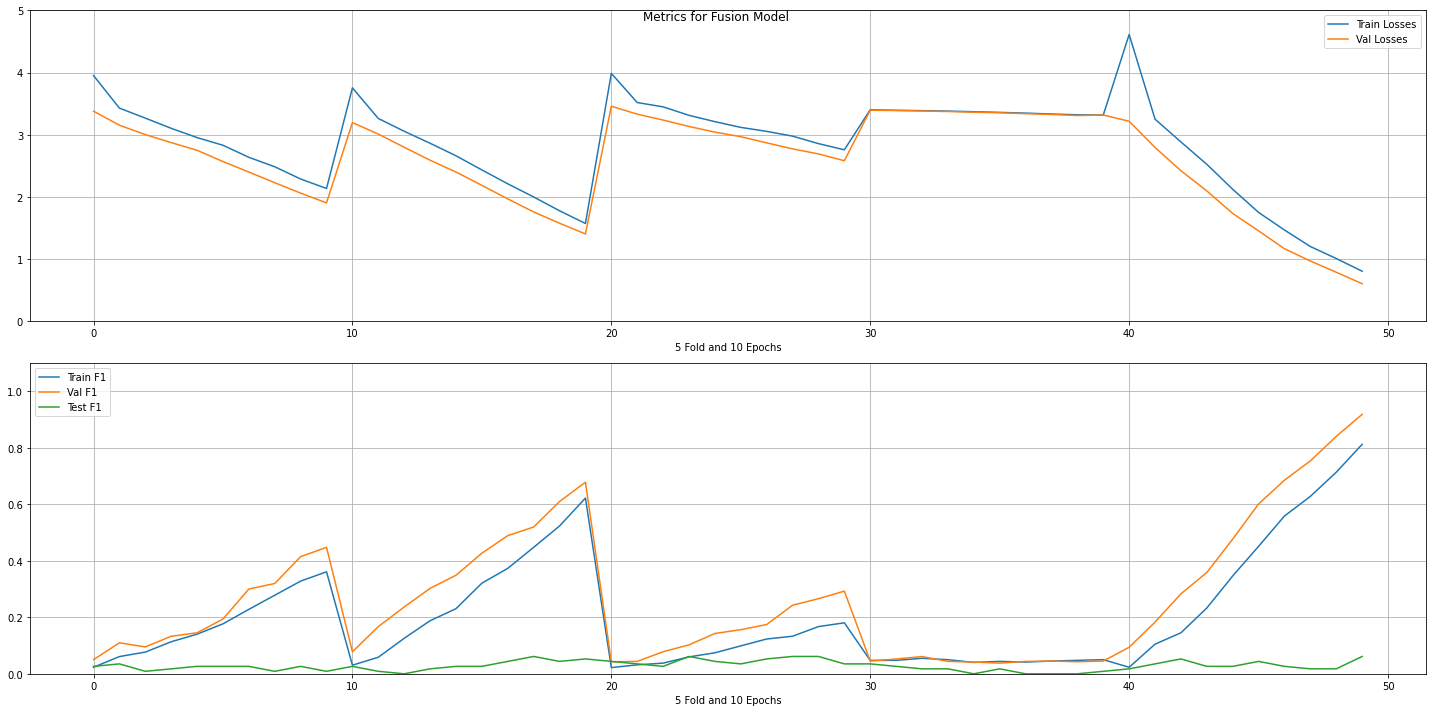

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.475854,0.475854,0.475854,0.031579,0.031579,0.031579,0.404634,0.404634,0.404634


In [20]:
sequences, attention_masks = get_seq_masks('ai4bharat/indic-bert',txt)
indic_bert_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/IndicBERT_FineTuned',
                                gpu, 'ai4bharat/indic-bert', n_labels=n_labels,feature='mfcc', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [21]:
display(HTML(results_to_df(indic_bert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.812195,0.918293,0.061404,0.812195,0.918293,0.061404,0.812195,0.918293,0.061404
8,0.713415,0.840244,0.017544,0.713415,0.840244,0.017544,0.713415,0.840244,0.017544
7,0.628049,0.753659,0.017544,0.628049,0.753659,0.017544,0.628049,0.753659,0.017544
6,0.558537,0.685366,0.026316,0.558537,0.685366,0.026316,0.558537,0.685366,0.026316
9,0.621951,0.678049,0.052632,0.621951,0.678049,0.052632,0.621951,0.678049,0.052632
8,0.523171,0.609756,0.043860,0.523171,0.609756,0.043860,0.523171,0.609756,0.043860
5,0.451220,0.601220,0.043860,0.451220,0.601220,0.043860,0.451220,0.601220,0.043860
7,0.447561,0.519512,0.061404,0.447561,0.519512,0.061404,0.447561,0.519512,0.061404
6,0.373171,0.489024,0.043860,0.373171,0.489024,0.043860,0.373171,0.489024,0.043860
4,0.346341,0.476829,0.026316,0.346341,0.476829,0.026316,0.346341,0.476829,0.026316


# MURIL Fusion

Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113 [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/10 : Training Loss: 4.295 / Validation Loss : 3.357 [Time : 22.434316 seconds]
Epoch 2/10 : Training Loss: 3.450 / Validation Loss : 3.163 [Time : 22.519416 seconds]
Epoch 3/10 : Training Loss: 3.283 / Validation Loss : 3.015 [Time : 22.448666 seconds]
Epoch 4/10 : Training Loss: 3.165 / Validation Loss : 2.912 [Time : 22.603045 seconds]
Epoch 5/10 : Training Loss: 3.010 / Validation Loss : 2.766 [Time : 22.576741 seconds]
Epoch 6/10 : Training Loss: 2.847 / Validation Loss : 2.596 [Time : 22.524 seconds]
Epoch 7/10 : Training Loss: 2.693 / Validation Loss : 2.464 [Time : 22.389669 seconds]
Epoch 8/10 : Training Loss: 2.529 / Valida

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.548 / Validation Loss : 3.364 [Time : 18.492532 seconds]
Epoch 2/10 : Training Loss: 3.370 / Validation Loss : 3.161 [Time : 17.862116 seconds]
Epoch 3/10 : Training Loss: 3.195 / Validation Loss : 3.054 [Time : 17.968438 seconds]
Epoch 4/10 : Training Loss: 3.101 / Validation Loss : 2.943 [Time : 17.888453 seconds]
Epoch 5/10 : Training Loss: 2.995 / Validation Loss : 2.819 [Time : 17.882294 seconds]
Epoch 6/10 : Training Loss: 2.870 / Validation Loss : 2.708 [Time : 17.865849 seconds]
Epoch 7/10 : Training Loss: 2.758 / Validation Loss : 2.577 [Time : 17.905881 seconds]
Epoch 8/10 : Training Loss: 2.644 / Validation Loss : 2.469 [Time : 17.921031 seconds]
Epoch 9/10 : Training Loss: 2.532 / Validation Loss : 2.349 [Time : 17.87415 seconds]
Epoch 10/10 : Training Loss: 2.413 / Validation Loss : 2.234 [Time : 17.860874 seconds]
*** Confusion Matrix - Training ***
[[13  0  0  0  1  0  0  0  1  1  3  0  0  2  0  2  0  2  2  0  1  0  1  0
   2  0  1  0  0  1]

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.477 / Validation Loss : 3.369 [Time : 18.357199 seconds]
Epoch 2/10 : Training Loss: 3.374 / Validation Loss : 3.314 [Time : 18.235178 seconds]
Epoch 3/10 : Training Loss: 3.330 / Validation Loss : 3.277 [Time : 17.910347 seconds]
Epoch 4/10 : Training Loss: 3.295 / Validation Loss : 3.237 [Time : 17.848018 seconds]
Epoch 5/10 : Training Loss: 3.253 / Validation Loss : 3.197 [Time : 17.882989 seconds]
Epoch 6/10 : Training Loss: 3.221 / Validation Loss : 3.157 [Time : 17.844384 seconds]
Epoch 7/10 : Training Loss: 3.177 / Validation Loss : 3.112 [Time : 17.861061 seconds]
Epoch 8/10 : Training Loss: 3.134 / Validation Loss : 3.067 [Time : 17.853922 seconds]
Epoch 9/10 : Training Loss: 3.087 / Validation Loss : 3.018 [Time : 17.830286 seconds]
Epoch 10/10 : Training Loss: 3.042 / Validation Loss : 2.971 [Time : 17.865917 seconds]
*** Confusion Matrix - Training ***
[[ 4  1  3  0  0  1  1  0  3  0  0  0  0  0  0  0  1  2  1  0  0  1  0  2
   0  0 10  0  1  1

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.814 / Validation Loss : 3.338 [Time : 18.366578 seconds]
Epoch 2/10 : Training Loss: 3.424 / Validation Loss : 3.208 [Time : 17.844027 seconds]
Epoch 3/10 : Training Loss: 3.264 / Validation Loss : 3.069 [Time : 17.830496 seconds]
Epoch 4/10 : Training Loss: 3.156 / Validation Loss : 2.946 [Time : 17.968981 seconds]
Epoch 5/10 : Training Loss: 3.014 / Validation Loss : 2.811 [Time : 17.858442 seconds]
Epoch 6/10 : Training Loss: 2.884 / Validation Loss : 2.687 [Time : 17.841438 seconds]
Epoch 7/10 : Training Loss: 2.729 / Validation Loss : 2.553 [Time : 17.911853 seconds]
Epoch 8/10 : Training Loss: 2.625 / Validation Loss : 2.416 [Time : 17.839541 seconds]
Epoch 9/10 : Training Loss: 2.483 / Validation Loss : 2.278 [Time : 17.885321 seconds]
Epoch 10/10 : Training Loss: 2.340 / Validation Loss : 2.139 [Time : 17.89857 seconds]
*** Confusion Matrix - Training ***
[[ 4  0  0  1  1  0  1  1  0  2  0  1  0  1  0  0  0  0  3  0  5  5  1  1
   1  0  3  2  0  0]

Some weights of the model checkpoint at /content/drive/MyDrive/MURIL_FineTuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 4.500 / Validation Loss : 3.464 [Time : 18.403376 seconds]
Epoch 2/10 : Training Loss: 3.614 / Validation Loss : 3.149 [Time : 17.880188 seconds]
Epoch 3/10 : Training Loss: 3.330 / Validation Loss : 3.052 [Time : 17.850766 seconds]
Epoch 4/10 : Training Loss: 3.168 / Validation Loss : 2.855 [Time : 17.883445 seconds]
Epoch 5/10 : Training Loss: 2.982 / Validation Loss : 2.690 [Time : 17.863466 seconds]
Epoch 6/10 : Training Loss: 2.836 / Validation Loss : 2.580 [Time : 17.832467 seconds]
Epoch 7/10 : Training Loss: 2.710 / Validation Loss : 2.375 [Time : 17.923742 seconds]
Epoch 8/10 : Training Loss: 2.496 / Validation Loss : 2.200 [Time : 17.843719 seconds]
Epoch 9/10 : Training Loss: 2.285 / Validation Loss : 2.030 [Time : 17.884016 seconds]
Epoch 10/10 : Training Loss: 2.134 / Validation Loss : 1.872 [Time : 22.328731 seconds]
*** Confusion Matrix - Training ***
[[17  0  2  0  0  0  2  2  0  0  1  0  0  1  0  0  0  1  0  0  0  2  0  1
   1  0  0  2  0  1

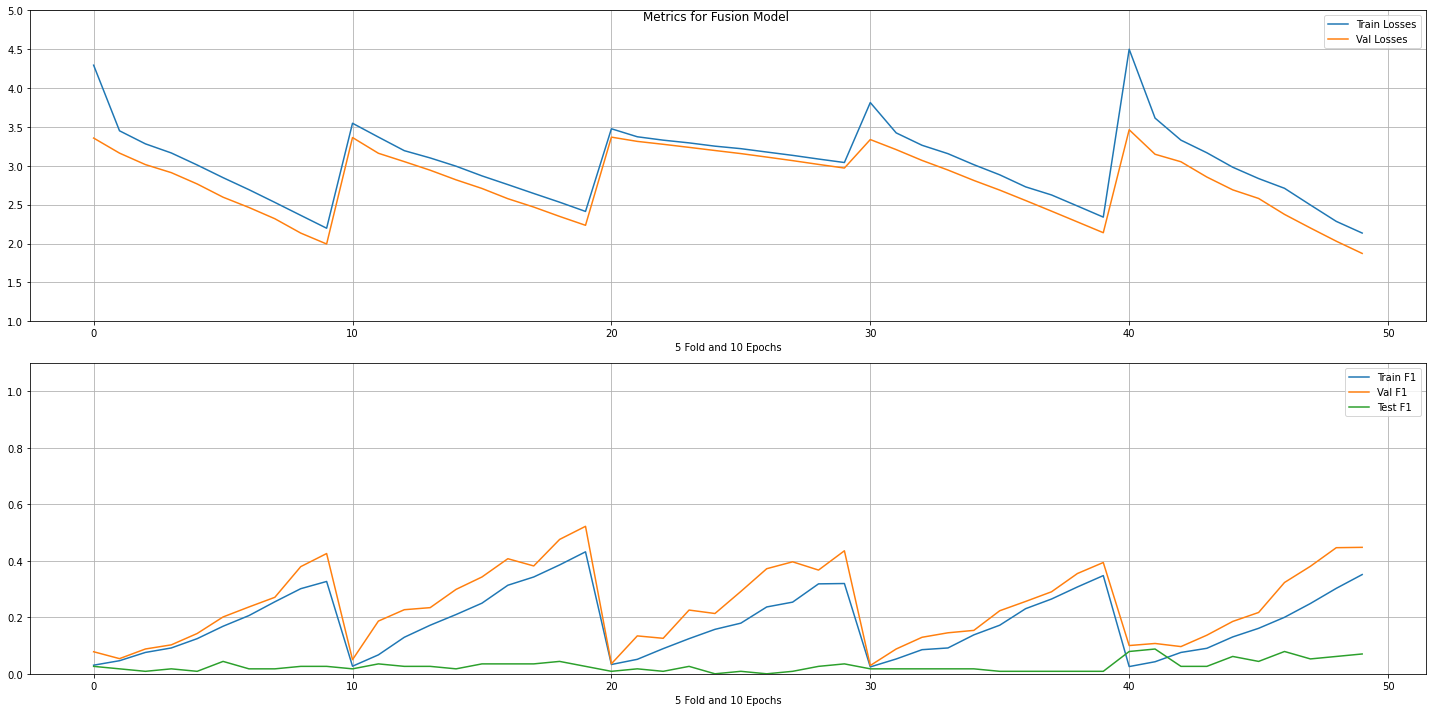

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.444878,0.444878,0.444878,0.033333,0.033333,0.033333,0.355366,0.355366,0.355366


In [22]:
sequences, attention_masks = get_seq_masks('google/muril-base-cased',txt)
muril_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/MURIL_FineTuned',
                                gpu, 'google/muril-base-cased', n_labels=n_labels,feature='mfcc', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [23]:
display(HTML(results_to_df(muril_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.431707,0.521951,0.026316,0.431707,0.521951,0.026316,0.431707,0.521951,0.026316
8,0.385366,0.475610,0.043860,0.385366,0.475610,0.043860,0.385366,0.475610,0.043860
9,0.351220,0.447561,0.070175,0.351220,0.447561,0.070175,0.351220,0.447561,0.070175
8,0.302439,0.446341,0.061404,0.302439,0.446341,0.061404,0.302439,0.446341,0.061404
9,0.319512,0.435366,0.035088,0.319512,0.435366,0.035088,0.319512,0.435366,0.035088
9,0.326829,0.425610,0.026316,0.326829,0.425610,0.026316,0.326829,0.425610,0.026316
6,0.313415,0.407317,0.035088,0.313415,0.407317,0.035088,0.313415,0.407317,0.035088
7,0.253659,0.396341,0.008772,0.253659,0.396341,0.008772,0.253659,0.396341,0.008772
9,0.347561,0.393902,0.008772,0.347561,0.393902,0.008772,0.347561,0.393902,0.008772
7,0.342683,0.381707,0.035088,0.342683,0.381707,0.035088,0.342683,0.381707,0.035088


# XLM-R Fusion

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/10 : Training Loss: 3.452 / Validation Loss : 3.365 [Time : 23.726984 seconds]
Epoch 2/10 : Training Loss: 3.369 / Validation Loss : 3.330 [Time : 23.546725 seconds]
Epoch 3/10 : Training Loss: 3.340 / Validation Loss : 3.297 [Time : 23.987887 seconds]
Epoch 4/10 : Training Loss: 3.308 / Validation Loss : 3.260 [Time : 23.521747 seconds]
Epoch 5/10 : Training Loss: 3.268 / Validation Loss : 3.223 [Time : 23.733929 seconds]
Epoch 6/10 : Training Loss: 3.232 / Validation Loss : 3.184 [Time : 23.535388 seconds]
Epoch 7/10 : Training Loss: 3.196 / Validation Loss : 3.142 [Time : 23.639847 seconds]
Epoch 8/10 : Training Loss: 3.155 / Val

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.473 / Validation Loss : 3.400 [Time : 18.720411 seconds]
Epoch 2/10 : Training Loss: 3.404 / Validation Loss : 3.381 [Time : 18.509773 seconds]
Epoch 3/10 : Training Loss: 3.394 / Validation Loss : 3.372 [Time : 18.546093 seconds]
Epoch 4/10 : Training Loss: 3.389 / Validation Loss : 3.365 [Time : 18.093543 seconds]
Epoch 5/10 : Training Loss: 3.377 / Validation Loss : 3.355 [Time : 18.100922 seconds]
Epoch 6/10 : Training Loss: 3.369 / Validation Loss : 3.342 [Time : 18.138921 seconds]
Epoch 7/10 : Training Loss: 3.360 / Validation Loss : 3.330 [Time : 18.056646 seconds]
Epoch 8/10 : Training Loss: 3.344 / Validation Loss : 3.317 [Time : 18.063415 seconds]
Epoch 9/10 : Training Loss: 3.340 / Validation Loss : 3.309 [Time : 18.114988 seconds]
Epoch 10/10 : Training Loss: 3.320 / Validation Loss : 3.292 [Time : 18.080964 seconds]
*** Confusion Matrix - Training ***
[[19  0  1  0  2  0  2  0  0  3  0  0  0  1  0  1  0  0  0  0  2  1  0  0
   0  0  0  1  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.479 / Validation Loss : 3.390 [Time : 18.669676 seconds]
Epoch 2/10 : Training Loss: 3.402 / Validation Loss : 3.350 [Time : 18.517915 seconds]
Epoch 3/10 : Training Loss: 3.371 / Validation Loss : 3.326 [Time : 18.544065 seconds]
Epoch 4/10 : Training Loss: 3.346 / Validation Loss : 3.303 [Time : 18.054626 seconds]
Epoch 5/10 : Training Loss: 3.322 / Validation Loss : 3.277 [Time : 18.061347 seconds]
Epoch 6/10 : Training Loss: 3.304 / Validation Loss : 3.251 [Time : 18.090762 seconds]
Epoch 7/10 : Training Loss: 3.273 / Validation Loss : 3.223 [Time : 18.097519 seconds]
Epoch 8/10 : Training Loss: 3.242 / Validation Loss : 3.193 [Time : 18.054566 seconds]
Epoch 9/10 : Training Loss: 3.219 / Validation Loss : 3.169 [Time : 18.099188 seconds]
Epoch 10/10 : Training Loss: 3.186 / Validation Loss : 3.133 [Time : 18.063631 seconds]
*** Confusion Matrix - Training ***
[[ 2  0  8  1  0  0  2  0  1  1  0  0  0  0  0  1  3  3  0  0  2  0  0  4
   1  1  1  0  0  1

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 4.645 / Validation Loss : 3.446 [Time : 18.565417 seconds]
Epoch 2/10 : Training Loss: 3.482 / Validation Loss : 3.257 [Time : 18.491764 seconds]
Epoch 3/10 : Training Loss: 3.319 / Validation Loss : 3.101 [Time : 18.542299 seconds]
Epoch 4/10 : Training Loss: 3.173 / Validation Loss : 2.979 [Time : 23.658732 seconds]
Epoch 5/10 : Training Loss: 3.085 / Validation Loss : 2.852 [Time : 23.604012 seconds]
Epoch 6/10 : Training Loss: 2.907 / Validation Loss : 2.731 [Time : 23.558324 seconds]
Epoch 7/10 : Training Loss: 2.781 / Validation Loss : 2.550 [Time : 23.709827 seconds]
Epoch 8/10 : Training Loss: 2.618 / Validation Loss : 2.444 [Time : 23.910264 seconds]
Epoch 9/10 : Training Loss: 2.450 / Validation Loss : 2.281 [Time : 24.021529 seconds]
Epoch 10/10 : Training Loss: 2.329 / Validation Loss : 2.143 [Time : 24.039327 seconds]
*** Confusion Matrix - Training ***
[[ 9  0  1  0  0  1  1  1  1  1  0  2  1  1  1  0  1  0  4  0  1  0  0  1
   1  0  2  1  0  2

Some weights of the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/XLMR_Finetuned/pytorch_model.bin and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Epoch 1/10 : Training Loss: 3.464 / Validation Loss : 3.358 [Time : 18.531173 seconds]
Epoch 2/10 : Training Loss: 3.359 / Validation Loss : 3.307 [Time : 18.007501 seconds]
Epoch 3/10 : Training Loss: 3.315 / Validation Loss : 3.259 [Time : 17.992498 seconds]
Epoch 4/10 : Training Loss: 3.269 / Validation Loss : 3.208 [Time : 18.009806 seconds]
Epoch 5/10 : Training Loss: 3.219 / Validation Loss : 3.153 [Time : 18.012771 seconds]
Epoch 6/10 : Training Loss: 3.166 / Validation Loss : 3.094 [Time : 18.029724 seconds]
Epoch 7/10 : Training Loss: 3.107 / Validation Loss : 3.035 [Time : 18.009633 seconds]
Epoch 8/10 : Training Loss: 3.051 / Validation Loss : 2.969 [Time : 18.030323 seconds]
Epoch 9/10 : Training Loss: 2.984 / Validation Loss : 2.906 [Time : 18.388781 seconds]
Epoch 10/10 : Training Loss: 2.924 / Validation Loss : 2.840 [Time : 18.030645 seconds]
*** Confusion Matrix - Training ***
[[15  0  0  1  2  1  2  1  0  0  4  0  0  0  1  0  0  2  2  0  0  0  0  1
   0  0  1  0  0  0

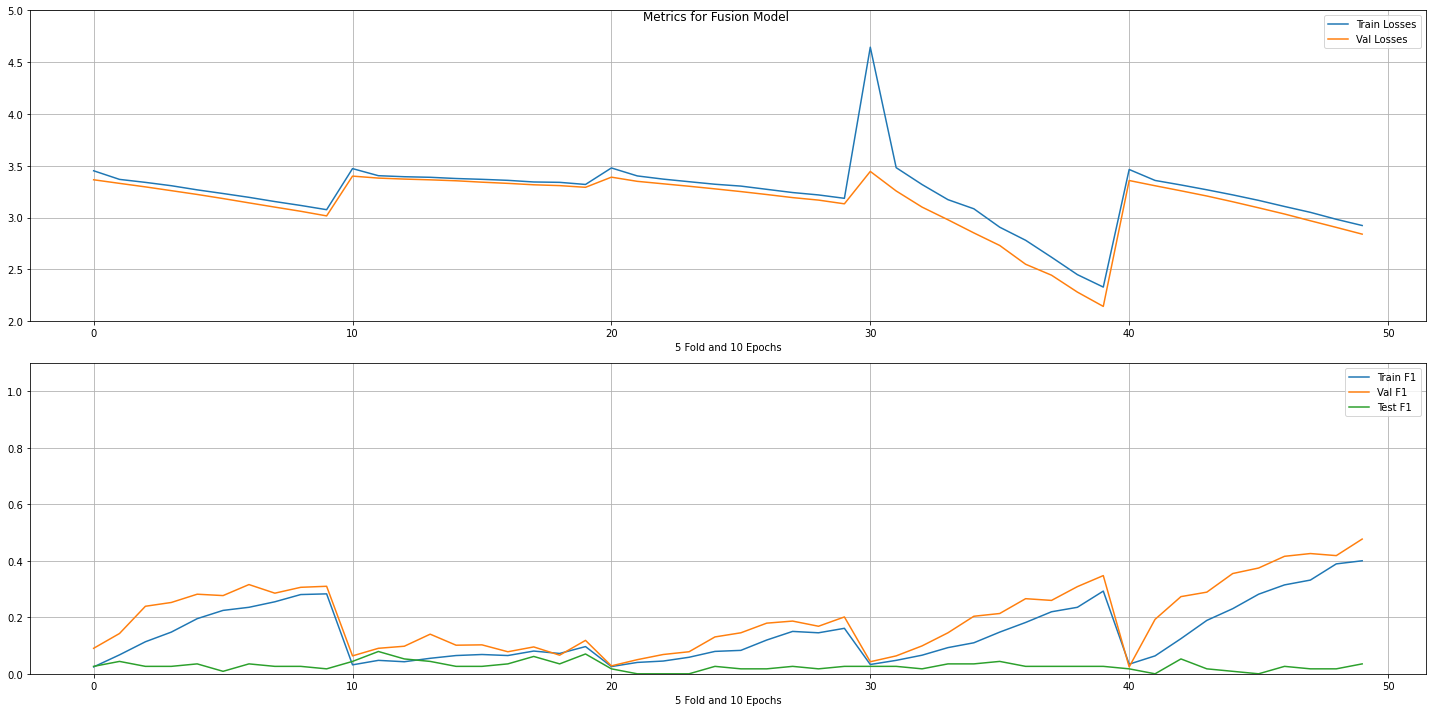

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.290732,0.290732,0.290732,0.035088,0.035088,0.035088,0.246585,0.246585,0.246585


In [24]:
sequences, attention_masks = get_seq_masks('xlm-roberta-base',txt)
xlmr_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/XLMR_Finetuned',
                                gpu, 'xlm-roberta-base', n_labels=n_labels,feature='mfcc', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [25]:
display(HTML(results_to_df(xlmr_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.400000,0.476829,0.035088,0.400000,0.476829,0.035088,0.400000,0.476829,0.035088
7,0.331707,0.425610,0.017544,0.331707,0.425610,0.017544,0.331707,0.425610,0.017544
8,0.389024,0.418293,0.017544,0.389024,0.418293,0.017544,0.389024,0.418293,0.017544
6,0.314634,0.415854,0.026316,0.314634,0.415854,0.026316,0.314634,0.415854,0.026316
5,0.281707,0.374390,0.000000,0.281707,0.374390,0.000000,0.281707,0.374390,0.000000
4,0.230488,0.354878,0.008772,0.230488,0.354878,0.008772,0.230488,0.354878,0.008772
9,0.292683,0.347561,0.026316,0.292683,0.347561,0.026316,0.292683,0.347561,0.026316
6,0.235366,0.315854,0.035088,0.235366,0.315854,0.035088,0.235366,0.315854,0.035088
9,0.282927,0.309756,0.017544,0.282927,0.309756,0.017544,0.282927,0.309756,0.017544
8,0.235366,0.308537,0.026316,0.235366,0.308537,0.026316,0.235366,0.308537,0.026316


# MBERT Fusion

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

FOLD 1 
 Data Sizes (Train/Validation) : 820/205


Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.83333333 2.27777778 2.00980392 1.36666667 2.62820513 3.10606061
 1.13888889 1.36666667 0.94907407 1.79824561 1.42361111 3.41666667
 0.75925926 0.52564103 2.84722222 1.13888889 1.31410256 2.00980392
 2.44047619 2.44047619 0.66993464 0.63271605 0.38825758 1.70833333
 0.56010929 1.2202381  0.56010929 0.4495614  3.41666667 0.39272031]
Epoch 1/10 : Training Loss: 3.457 / Validation Loss : 3.353 [Time : 20.31649 seconds]
Epoch 2/10 : Training Loss: 3.357 / Validation Loss : 3.308 [Time : 20.452169 seconds]
Epoch 3/10 : Training Loss: 3.316 / Validation Loss : 3.261 [Time : 20.520433 seconds]
Epoch 4/10 : Training Loss: 3.277 / Validation Loss : 3.216 [Time : 20.485898 seconds]
Epoch 5/10 : Training Loss: 3.224 / Validation Loss : 3.169 [Time : 20.565733 seconds]
Epoch 6/10 : Training Loss: 3.183 / Validation Loss : 3.123 [Time : 20.317161 seconds]
Epoch 7/10 : Training Loss: 3.145 / Validation Loss : 3.081 [Time : 20.509135 seconds]
Epoch 8/10 : Training Loss: 3.093 / Vali

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.413 / Validation Loss : 3.375 [Time : 17.590134 seconds]
Epoch 2/10 : Training Loss: 3.372 / Validation Loss : 3.348 [Time : 17.422533 seconds]
Epoch 3/10 : Training Loss: 3.347 / Validation Loss : 3.319 [Time : 17.139684 seconds]
Epoch 4/10 : Training Loss: 3.319 / Validation Loss : 3.288 [Time : 17.046474 seconds]
Epoch 5/10 : Training Loss: 3.294 / Validation Loss : 3.257 [Time : 16.990765 seconds]
Epoch 6/10 : Training Loss: 3.265 / Validation Loss : 3.230 [Time : 17.053879 seconds]
Epoch 7/10 : Training Loss: 3.233 / Validation Loss : 3.190 [Time : 17.409136 seconds]
Epoch 8/10 : Training Loss: 3.197 / Validation Loss : 3.161 [Time : 17.016581 seconds]
Epoch 9/10 : Training Loss: 3.166 / Validation Loss : 3.130 [Time : 17.062689 seconds]
Epoch 10/10 : Training Loss: 3.136 / Validation Loss : 3.094 [Time : 17.020919 seconds]
*** Confusion Matrix - Training ***
[[18  1  6  1  0  0  2  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0
   0  0  0  0  0  0

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.599 / Validation Loss : 3.294 [Time : 17.538921 seconds]
Epoch 2/10 : Training Loss: 3.324 / Validation Loss : 3.077 [Time : 17.477088 seconds]
Epoch 3/10 : Training Loss: 3.118 / Validation Loss : 2.921 [Time : 20.712579 seconds]
Epoch 4/10 : Training Loss: 2.971 / Validation Loss : 2.753 [Time : 20.604745 seconds]
Epoch 5/10 : Training Loss: 2.800 / Validation Loss : 2.596 [Time : 20.453297 seconds]
Epoch 6/10 : Training Loss: 2.619 / Validation Loss : 2.440 [Time : 20.404399 seconds]
Epoch 7/10 : Training Loss: 2.456 / Validation Loss : 2.252 [Time : 20.375215 seconds]
Epoch 8/10 : Training Loss: 2.320 / Validation Loss : 2.093 [Time : 20.466912 seconds]
Epoch 9/10 : Training Loss: 2.100 / Validation Loss : 1.923 [Time : 20.561145 seconds]
Epoch 10/10 : Training Loss: 1.969 / Validation Loss : 1.784 [Time : 20.385322 seconds]
*** Confusion Matrix - Training ***
[[16  0  3  0  0  0  1  0  1  1  0  0  0  2  0  0  0  1  0  0  0  0  1  2
   0  0  2  0  0  2

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.500 / Validation Loss : 3.299 [Time : 17.231963 seconds]
Epoch 2/10 : Training Loss: 3.314 / Validation Loss : 3.138 [Time : 16.989606 seconds]
Epoch 3/10 : Training Loss: 3.148 / Validation Loss : 3.010 [Time : 16.994399 seconds]
Epoch 4/10 : Training Loss: 3.040 / Validation Loss : 2.877 [Time : 17.02367 seconds]
Epoch 5/10 : Training Loss: 2.909 / Validation Loss : 2.739 [Time : 16.994948 seconds]
Epoch 6/10 : Training Loss: 2.776 / Validation Loss : 2.599 [Time : 16.995016 seconds]
Epoch 7/10 : Training Loss: 2.639 / Validation Loss : 2.462 [Time : 17.004311 seconds]
Epoch 8/10 : Training Loss: 2.498 / Validation Loss : 2.325 [Time : 17.051297 seconds]
Epoch 9/10 : Training Loss: 2.367 / Validation Loss : 2.204 [Time : 17.019845 seconds]
Epoch 10/10 : Training Loss: 2.240 / Validation Loss : 2.064 [Time : 17.033894 seconds]
*** Confusion Matrix - Training ***
[[18  1  1  0  0  0  0  0  0  1  4  0  0  1  0  0  0  0  2  0  3  0  0  1
   0  0  0  1  0  0]

Some weights of the model checkpoint at /content/drive/MyDrive/MBERT_Finetuned/pytorch_model.bin were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.659 / Validation Loss : 3.221 [Time : 17.213584 seconds]
Epoch 2/10 : Training Loss: 3.244 / Validation Loss : 3.008 [Time : 17.073799 seconds]
Epoch 3/10 : Training Loss: 3.033 / Validation Loss : 2.782 [Time : 17.025325 seconds]
Epoch 4/10 : Training Loss: 2.845 / Validation Loss : 2.564 [Time : 17.00735 seconds]
Epoch 5/10 : Training Loss: 2.609 / Validation Loss : 2.338 [Time : 17.040524 seconds]
Epoch 6/10 : Training Loss: 2.379 / Validation Loss : 2.138 [Time : 17.030917 seconds]
Epoch 7/10 : Training Loss: 2.170 / Validation Loss : 1.923 [Time : 16.977862 seconds]
Epoch 8/10 : Training Loss: 1.951 / Validation Loss : 1.738 [Time : 20.448872 seconds]
Epoch 9/10 : Training Loss: 1.749 / Validation Loss : 1.549 [Time : 20.520129 seconds]
Epoch 10/10 : Training Loss: 1.573 / Validation Loss : 1.384 [Time : 20.380541 seconds]
*** Confusion Matrix - Training ***
[[21  0  0  0  0  1  0  1  0  0  0  0  1  1  0  1  0  0  2  0  0  1  0  2
   0  0  1  0  0  1]

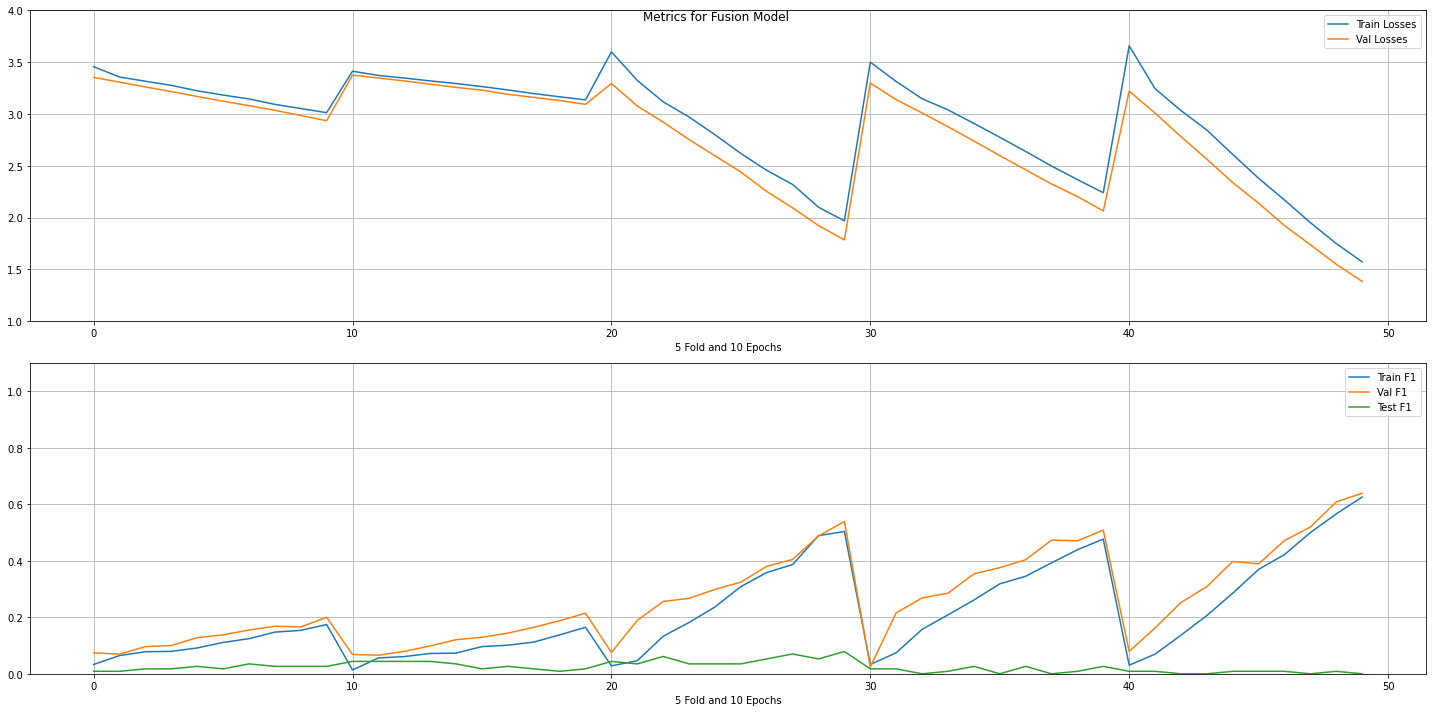

*** Cross Validation Score ***


,validation_f1,validation_precision,validation_recall,test_f1,test_precision,test_recall,train_f1,train_precision,train_recall
0,0.420244,0.420244,0.420244,0.029825,0.029825,0.029825,0.389024,0.389024,0.389024


In [26]:
sequences, attention_masks = get_seq_masks('bert-base-multilingual-cased',txt)
mbert_result = train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/MBERT_Finetuned',
                                gpu, 'bert-base-multilingual-cased', n_labels=n_labels,feature='mfcc', title='Fusion Model',
                                epochs=10, target='RagamCode', model=FusionModel, lr=1e-5, mdlargs={'n_labels':n_labels})

In [27]:
display(HTML(results_to_df(mbert_result)[res_tbl_keys].to_html().replace("\\n", "<br>")))

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.625610,0.639024,0.000000,0.625610,0.639024,0.000000,0.625610,0.639024,0.000000
8,0.565854,0.608537,0.008772,0.565854,0.608537,0.008772,0.565854,0.608537,0.008772
9,0.503659,0.539024,0.078947,0.503659,0.539024,0.078947,0.503659,0.539024,0.078947
7,0.500000,0.519512,0.000000,0.500000,0.519512,0.000000,0.500000,0.519512,0.000000
9,0.476829,0.508537,0.026316,0.476829,0.508537,0.026316,0.476829,0.508537,0.026316
8,0.489024,0.487805,0.052632,0.489024,0.487805,0.052632,0.489024,0.487805,0.052632
7,0.392683,0.473171,0.000000,0.392683,0.473171,0.000000,0.392683,0.473171,0.000000
6,0.421951,0.471951,0.008772,0.421951,0.471951,0.008772,0.421951,0.471951,0.008772
8,0.439024,0.470732,0.008772,0.439024,0.470732,0.008772,0.439024,0.470732,0.008772
7,0.386585,0.404878,0.070175,0.386585,0.404878,0.070175,0.386585,0.404878,0.070175
